In [1]:
import os
import boa
import warnings
import random
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Setup

In [2]:
filename = "./impl_comparison_data.csv"

Generate admin and fee receiver addresses (shared between old and new versions):

In [3]:
admin = boa.env.generate_address()
fee_receiver = boa.env.generate_address()
trader = boa.env.generate_address()
zero_address = boa.eval("empty(address)")
print(admin, fee_receiver, trader)

0xd13f0Bd22AFF8176761AEFBfC052a7490bDe268E 0xA73d7cddCf77c00827459f986bf828999B58C6Fe 0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B


Generate coins and coin holders for trading ...

In [4]:
coin_a = boa.load("../../contracts/mocks/ERC20Mock.vy", "coin_a", "coin_a", 18)
coin_b = boa.load("../../contracts/mocks/ERC20Mock.vy", "coin_b", "coin_b", 18)

coin_a._mint_for_testing(trader, 10**50, sender=trader)
coin_b._mint_for_testing(trader, 10**50, sender=trader)
print(coin_a, coin_b)

<../../contracts/mocks/ERC20Mock.vy at 0x2cb6bCe32aeF4eD506382896e702DE7Ff109D9E9, compiled with vyper-0.3.10+9136169>
<storage: name=coin_a                          , symbol=coin_a                          , decimals=18, balanceOf={'0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B': 100000000000000000000000000000000000000000000000000}, allowances={}, totalSupply=100000000000000000000000000000000000000000000000000> <../../contracts/mocks/ERC20Mock.vy at 0xB822167C7EefF0B53DcfDEE2D8fe73dEDB25505b, compiled with vyper-0.3.10+9136169>
<storage: name=coin_b                          , symbol=coin_b                          , decimals=18, balanceOf={'0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B': 100000000000000000000000000000000000000000000000000}, allowances={}, totalSupply=100000000000000000000000000000000000000000000000000>


Pool parameters:

In [5]:
A = 400000
gamma = 145000000000000
mid_fee = 26000000
out_fee = 45000000
allowed_extra_profit = 2000000000000
fee_gamma = 230000000000000
adjustment_step = 146000000000000
ma_time = 600
xcp_ma_time = 1800 * 24
initial_price = 10**18  # 1:1 at the start
admin_fee = 5 * 10**9

Instantiate contracts for factory:

In [6]:
old_swap_implementation = boa.load(
    "../../contracts/old/CurveCryptoSwap2ETH.vy", 
    boa.env.generate_address()  # use some random address as weth
)
old_math = boa.load("../../contracts/old/CurveCryptoSwap2Math.vy")
old_token = boa.load("../../contracts/old/CurveCryptoLPToken.vy")

with boa.env.prank(admin):
    old_factory = boa.load(
        "../../contracts/old/CurveCryptoFactory.vy",
        fee_receiver,
        old_swap_implementation,
        old_token,
        zero_address,
        zero_address
    )

old_swap = old_factory.deploy_pool(
    "old", "old", [coin_a.address, coin_b.address],
    A, gamma, mid_fee, out_fee, allowed_extra_profit, fee_gamma, 
    adjustment_step, admin_fee, ma_time, initial_price
)
old_swap = boa.load_partial("../../contracts/old/CurveCryptoSwap2ETH.vy").at(old_swap)
old_swap_token = boa.load_partial("../../contracts/mocks/ERC20Mock.vy").at(old_swap.token())
old_swap, old_swap_token

(<../../contracts/old/CurveCryptoSwap2ETH.vy at 0x5a0c986Eb1fED63bccD967298f5A87739951722E, compiled with vyper-0.3.10+9136169>
 <storage: token=0x5Bac22268eecccDF2fa09D03eC0D0fDbA2848ba2, coins=['0x2cb6bCe32aeF4eD506382896e702DE7Ff109D9E9', '0xB822167C7EefF0B53DcfDEE2D8fe73dEDB25505b'], price_scale=1000000000000000000, _price_oracle=1000000000000000000, last_prices=1000000000000000000, last_prices_timestamp=1704812576, initial_A_gamma=136112946768375385385349842972852284582400000, future_A_gamma=136112946768375385385349842972852284582400000, initial_A_gamma_time=0, future_A_gamma_time=0, allowed_extra_profit=2000000000000, future_allowed_extra_profit=0, fee_gamma=230000000000000, future_fee_gamma=0, adjustment_step=146000000000000, future_adjustment_step=0, ma_half_time=600, future_ma_half_time=0, mid_fee=26000000, out_fee=45000000, admin_fee=5000000000, future_mid_fee=0, future_out_fee=0, future_admin_fee=0, balances=[0, 0], D=0, factory=0xC6Acb7D16D51f72eAA659668F30A40d87E2E0551, xc

In [7]:
ng_swap_implementation = boa.load_partial("../../contracts/main/CurveTwocryptoOptimized.vy")
ng_math = boa.load("../../contracts/main/CurveCryptoMathOptimized2.vy")
ng_views = boa.load("../../contracts/main/CurveCryptoViews2Optimized.vy")
with boa.env.prank(admin):
    ng_factory = boa.load("../../contracts/main/CurveTwocryptoFactory.vy")
    ng_factory.initialise_ownership(fee_receiver, admin)

    ng_factory.set_pool_implementation(ng_swap_implementation.deploy_as_blueprint().address, 0)
    ng_factory.set_gauge_implementation(zero_address)
    ng_factory.set_views_implementation(ng_views.address)
    ng_factory.set_math_implementation(ng_math.address)

ng_swap = ng_factory.deploy_pool(
    "ng", "ng", [coin_a.address, coin_b.address],
    0, A, gamma, mid_fee, out_fee, fee_gamma, allowed_extra_profit, adjustment_step, int(ma_time/0.693), initial_price
)
ng_swap = ng_swap_implementation.at(ng_swap)
ng_swap

<../../contracts/main/CurveTwocryptoOptimized.vy at 0xF06589Ef7D9a8B4d14f45E36fAa3FDC4070693EF, compiled with vyper-0.3.10+9136169>
<storage: cached_price_scale=1000000000000000000, cached_price_oracle=1000000000000000000, cached_xcp_oracle=0, last_prices=1000000000000000000, last_timestamp=580117658517862290234477546148741508808920883232, last_xcp=0, xcp_ma_time=62324, initial_A_gamma=136112946768375385385349842972852284582400000, initial_A_gamma_time=0, future_A_gamma=136112946768375385385349842972852284582400000, future_A_gamma_time=0, balances=[0, 0], D=0, xcp_profit=0, xcp_profit_a=1000000000000000000, virtual_price=0, packed_rebalancing_params=680564733841876929619973849625130958848000000000865, packed_fee_params=8847341539944400050877843276543133320576000000, last_admin_fee_claim_timestamp=0, admin_lp_virtual_balance=0, balanceOf={}, allowance={}, totalSupply=0, nonces={}>

Grant approvals etc.

In [8]:
with boa.env.prank(trader):
    for coin in [coin_a, coin_b]:
        for pool in [old_swap, ng_swap]:
            coin.approve(pool, 2**256-1)

print(coin_a._storage.allowances.get())
print(coin_b._storage.allowances.get())

{'0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B': {'0xF06589Ef7D9a8B4d14f45E36fAa3FDC4070693EF': 115792089237316195423570985008687907853269984665640564039457584007913129639935, '0x5a0c986Eb1fED63bccD967298f5A87739951722E': 115792089237316195423570985008687907853269984665640564039457584007913129639935}}
{'0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B': {'0xF06589Ef7D9a8B4d14f45E36fAa3FDC4070693EF': 115792089237316195423570985008687907853269984665640564039457584007913129639935, '0x5a0c986Eb1fED63bccD967298f5A87739951722E': 115792089237316195423570985008687907853269984665640564039457584007913129639935}}


Add liquidity:

In [9]:
def _get_deposit_amounts(amount_per_token_usd, initial_prices, coins):

    precisions = [10 ** coin.decimals() for coin in coins]

    deposit_amounts = [
        amount_per_token_usd * precision * 10**18 // price
        for price, precision in zip(initial_prices, precisions)
    ]
    return deposit_amounts

deposit_amounts = _get_deposit_amounts(10**8, [10**18, initial_price], [coin_a, coin_b])
deposit_amounts

[100000000000000000000000000, 100000000000000000000000000]

In [10]:
if ng_swap.totalSupply() == 0:
    lp_tokens_ng = ng_swap.add_liquidity(deposit_amounts, 0, sender=trader)
if old_swap_token.totalSupply() == 0:
    lp_tokens_old = old_swap.add_liquidity(deposit_amounts, 0, sender=trader)
    
lp_tokens_ng - lp_tokens_old

0

In [11]:
ng_swap

<../../contracts/main/CurveTwocryptoOptimized.vy at 0xF06589Ef7D9a8B4d14f45E36fAa3FDC4070693EF, compiled with vyper-0.3.10+9136169>
<storage: cached_price_scale=1000000000000000000, cached_price_oracle=1000000000000000000, cached_xcp_oracle=100000000000000000000000000, last_prices=1000000000000000000, last_timestamp=580117658517862290234477546148741508808920883232, last_xcp=0, xcp_ma_time=62324, initial_A_gamma=136112946768375385385349842972852284582400000, initial_A_gamma_time=0, future_A_gamma=136112946768375385385349842972852284582400000, future_A_gamma_time=0, balances=[100000000000000000000000000, 100000000000000000000000000], D=200000000000000000000000000, xcp_profit=1000000000000000000, xcp_profit_a=1000000000000000000, virtual_price=1000000000000000000, packed_rebalancing_params=680564733841876929619973849625130958848000000000865, packed_fee_params=8847341539944400050877843276543133320576000000, last_admin_fee_claim_timestamp=0, admin_lp_virtual_balance=0, balanceOf={'0x1fb0aF0

In [12]:
old_swap

<../../contracts/old/CurveCryptoSwap2ETH.vy at 0x5a0c986Eb1fED63bccD967298f5A87739951722E, compiled with vyper-0.3.10+9136169>
<storage: token=0x5Bac22268eecccDF2fa09D03eC0D0fDbA2848ba2, coins=['0x2cb6bCe32aeF4eD506382896e702DE7Ff109D9E9', '0xB822167C7EefF0B53DcfDEE2D8fe73dEDB25505b'], price_scale=1000000000000000000, _price_oracle=1000000000000000000, last_prices=1000000000000000000, last_prices_timestamp=1704812576, initial_A_gamma=136112946768375385385349842972852284582400000, future_A_gamma=136112946768375385385349842972852284582400000, initial_A_gamma_time=0, future_A_gamma_time=0, allowed_extra_profit=2000000000000, future_allowed_extra_profit=0, fee_gamma=230000000000000, future_fee_gamma=0, adjustment_step=146000000000000, future_adjustment_step=0, ma_half_time=600, future_ma_half_time=0, mid_fee=26000000, out_fee=45000000, admin_fee=5000000000, future_mid_fee=0, future_out_fee=0, future_admin_fee=0, balances=[100000000000000000000000000, 100000000000000000000000000], D=2000000

## Compare trades

In [13]:
num_trades = 10000
data = {
    "timestamp": [],
    "i": [],
    "in_amt": [],
    "old_swap_out_amt": [],
    "ng_swap_out_amt": [],
    "old_swap_balances_a": [],
    "old_swap_balances_b": [],
    "ng_swap_balances_a": [],
    "ng_swap_balances_b": [],
    "old_swap_xcp_profit": [],
    "ng_swap_xcp_profit": [],
    "old_swap_D": [],
    "ng_swap_D": [],
    "old_swap_lp_price": [],
    "ng_swap_lp_price": [],
    "old_swap_virtual_price": [],
    "ng_swap_virtual_price": [],
    "old_swap_price_scale": [],
    "old_swap_price_oracle": [],
    "ng_swap_price_scale": [],
    "ng_swap_price_oracle": [],
    "ng_swap_xcp_oracle": [],
    "old_swap_last_price": [],
    "ng_swap_last_price": [],
    "ng_fee_receiver_balances_a": [],
    "ng_fee_receiver_balances_b": [],
    "old_fee_receiver_admin_balances": [],
    "old_swap_totalSupply": [],
    "ng_swap_totalSupply": [],
    "old_swap_fee": [],
    "ng_swap_fee": [],
}

In [14]:
if not os.path.exists(filename):

    coin_precisions = {0: 10**coin_a.decimals(), 1: 10**coin_b.decimals()}

    for _ in range(num_trades):
        
        i = random.randint(0, 1)
        trade_amount = random.randint(1, 10**4 * coin_precisions[i])
        
        out_old = old_swap.exchange(i, 1-i, trade_amount, 0, sender=trader)
        out_ng = ng_swap.exchange(i, 1-i, trade_amount, 0, sender=trader)
        
        # store data:
        data["timestamp"].append(boa.env.evm.patch.timestamp)
        
        data["old_swap_out_amt"].append(out_old / coin_precisions[1-i])
        data["ng_swap_out_amt"].append(out_ng / coin_precisions[1-1])
        data["i"].append(i)
        data["in_amt"].append(trade_amount / coin_precisions[i])
        
        balances = old_swap._storage.balances.get()
        data["old_swap_balances_a"].append(balances[0] / coin_precisions[0])
        data["old_swap_balances_b"].append(balances[1] / coin_precisions[1])
        data["old_swap_D"].append(old_swap._storage.D.get() / 1e18)
        data["old_swap_xcp_profit"].append(old_swap._storage.xcp_profit.get() / 1e18)
        data["old_swap_price_oracle"].append(old_swap.price_oracle() / 1e18)
        data["old_swap_price_scale"].append(old_swap.price_scale() / 1e18)
        data["old_swap_last_price"].append(old_swap.last_prices() / 1e18)
        data["old_swap_virtual_price"].append(old_swap.virtual_price() / 1e18)
        data["old_swap_lp_price"].append(old_swap.lp_price() / 1e18)
        data["old_fee_receiver_admin_balances"].append(old_swap_token.balanceOf(fee_receiver))
        data["old_swap_totalSupply"].append(old_swap_token._storage.totalSupply.get())
        data["old_swap_fee"].append(old_swap.fee())
        
        balances = ng_swap._storage.balances.get()
        data["ng_swap_balances_a"].append(balances[0] / coin_precisions[0])
        data["ng_swap_balances_b"].append(balances[1] / coin_precisions[1])
        data["ng_swap_D"].append(ng_swap._storage.D.get() / 1e18)
        data["ng_swap_xcp_profit"].append(ng_swap._storage.xcp_profit.get() / 1e18)
        data["ng_swap_price_oracle"].append(ng_swap.price_oracle() / 1e18)
        data["ng_swap_xcp_oracle"].append(ng_swap.xcp_oracle() / 1e18)
        data["ng_swap_price_scale"].append(ng_swap.price_scale() / 1e18)
        data["ng_swap_last_price"].append(ng_swap.last_prices() / 1e18)
        data["ng_swap_virtual_price"].append(ng_swap.virtual_price() / 1e18)
        data["ng_swap_lp_price"].append(ng_swap.lp_price() / 1e18)
        data["ng_swap_totalSupply"] = ng_swap._storage.totalSupply.get()
        data["ng_swap_fee"].append(ng_swap.fee())

        with boa.env.anchor():
            ng_swap.remove_liquidity_one_coin(10**18, i, 0, sender=trader)
            data["ng_fee_receiver_balances_a"].append(coin_a.balanceOf(fee_receiver) / coin_precisions[0])
            data["ng_fee_receiver_balances_b"].append(coin_b.balanceOf(fee_receiver) / coin_precisions[1])
        
        boa.env.time_travel(random.randint(1, 1000))
        
    df = pd.DataFrame(data)
    df.set_index("timestamp", inplace=True)
    
else:
    
    df = pd.read_csv(filename, index_col="timestamp")

df
    

,i,in_amt,old_swap_out_amt,ng_swap_out_amt,old_swap_balances_a,old_swap_balances_b,ng_swap_balances_a,ng_swap_balances_b,old_swap_xcp_profit,ng_swap_xcp_profit,...,ng_swap_xcp_oracle,old_swap_last_price,ng_swap_last_price,ng_fee_receiver_balances_a,ng_fee_receiver_balances_b,old_fee_receiver_admin_balances,old_swap_totalSupply,ng_swap_totalSupply,old_swap_fee,ng_swap_fee
timestamp,,,,,,,,,,,,,,,,,,,,,
1704812576,1,1202.113809,1198.987626,1198.987626,9.999880e+07,1.000012e+08,9.999880e+07,1.000012e+08,1.000000,1.000000,...,1.000000e+08,0.997399,0.999999,0.390682,0.390692,0,100000000000000000000000000,100000000000000000000000000,26000011,26000011
1704812854,1,4897.559579,4884.808795,4884.808795,9.999392e+07,1.000061e+08,9.999392e+07,1.000061e+08,1.000000,1.000000,...,1.000000e+08,0.997397,0.999994,1.982291,1.982533,0,100000000000000000000000000,100000000000000000000000000,26000306,26000306
1704813281,1,4916.058478,4903.236301,4903.236301,9.998901e+07,1.000110e+08,9.998901e+07,1.000110e+08,1.000000,1.000000,...,1.000000e+08,0.997392,0.999990,3.579794,3.580582,0,100000000000000000000000000,100000000000000000000000000,26000999,26000999
1704813307,0,4910.790854,4898.062521,4898.062521,9.999392e+07,1.000061e+08,9.999392e+07,1.000061e+08,1.000000,1.000000,...,1.000000e+08,1.002599,0.999994,5.175906,5.176537,0,100000000000000000000000000,100000000000000000000000000,26000307,26000307
1704814205,0,4800.712531,4788.247530,4788.247530,9.999872e+07,1.000013e+08,9.999872e+07,1.000013e+08,1.000000,1.000000,...,1.000000e+08,1.002603,0.999999,6.736371,6.736547,0,100000000000000000000000000,100000000000000000000000000,26000014,26000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1709797231,1,3135.511373,3132.688618,3122.204348,9.994751e+07,1.001793e+08,9.993906e+07,1.001885e+08,1.000326,1.000649,...,1.000629e+08,0.999100,0.998352,16193.252950,16233.676638,16256405153549384078350,100016256405153549384078350,100000000000000000000000000,26430404,26016202
1709797968,1,4127.665852,4125.192816,4110.132462,9.994339e+07,1.001834e+08,9.993495e+07,1.001927e+08,1.000326,1.000649,...,1.000629e+08,0.999401,0.998348,16193.925783,16235.687705,16256405153549384078350,100016256405153549384078350,100000000000000000000000000,26400052,26019349
1709798589,1,3193.109520,3190.441633,3179.533832,9.994020e+07,1.001866e+08,9.993177e+07,1.001959e+08,1.000326,1.000649,...,1.000629e+08,0.999164,0.998345,16194.446307,16237.243619,16256405153549384078350,100016256405153549384078350,100000000000000000000000000,26347964,26021975


In [15]:
if not os.path.exists(filename):
    df.to_csv(filename)

Comparisons:

1. Differences in outputs
2. Differences Price oracle updates
3. Differences in price scale updates
4. Differences in abs(price_scale - price_oracle)
5. Differences in pool balances
6. Differences in D
7. Differences in xcp profit
8. Differences in admin balances

In [16]:
def print_diff(loc):
    
    calc_diff = lambda x: print(f"{x}: " + str(df.loc[loc, f"old_swap_{x}"] - df.loc[loc, f"ng_swap_{x}"]))
    i = df.loc[loc, "i"]
    print(f"Traded {i} > {1-i}, in amount: {df.loc[loc, 'in_amt']}")
    print("Difference between old_swap and ng_swap:")
    
    calc_diff("out_amt")
    calc_diff("balances_a")
    calc_diff("balances_b")
    calc_diff("D")
    calc_diff("xcp_profit")
    calc_diff("virtual_price")
    calc_diff("last_price")
    calc_diff("price_oracle")
    calc_diff("price_scale")
    calc_diff("lp_price")

Text(0.5, 0.98, 'blue=old, orange=ng')

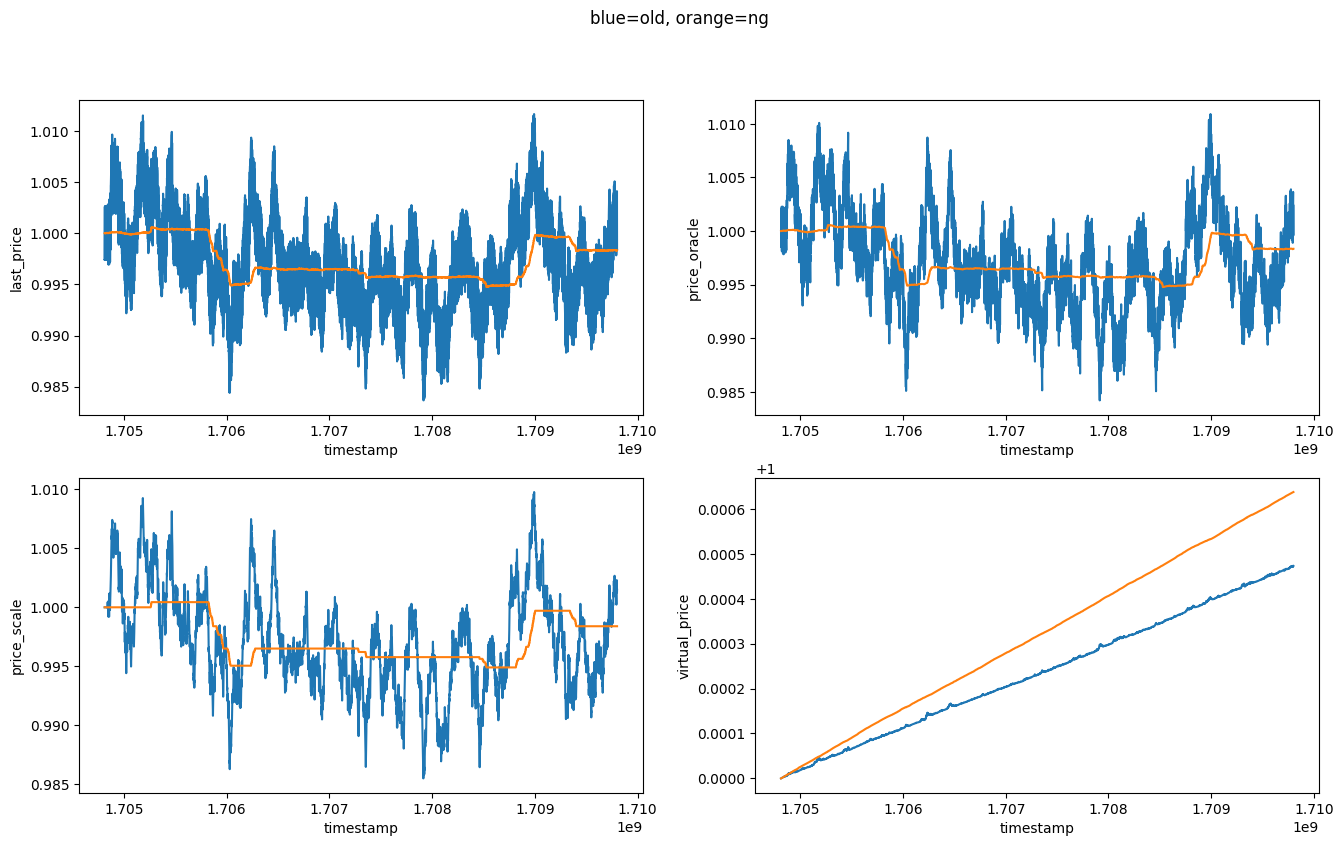

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))
df[["old_swap_last_price", "ng_swap_last_price"]].plot(ax=ax[0][0], legend=False, ylabel="last_price")
df[["old_swap_price_oracle", "ng_swap_price_oracle"]].plot(ax=ax[0][1], legend=False, ylabel="price_oracle")
df[["old_swap_price_scale", "ng_swap_price_scale"]].plot(ax=ax[1][0], legend=False, ylabel="price_scale")
df[["old_swap_virtual_price", "ng_swap_virtual_price"]].plot(ax=ax[1][1], legend=False, ylabel="virtual_price")

fig.suptitle("blue=old, orange=ng")

It seems ng is more 'stable' ? let's compare scale deltas

<Axes: xlabel='timestamp'>

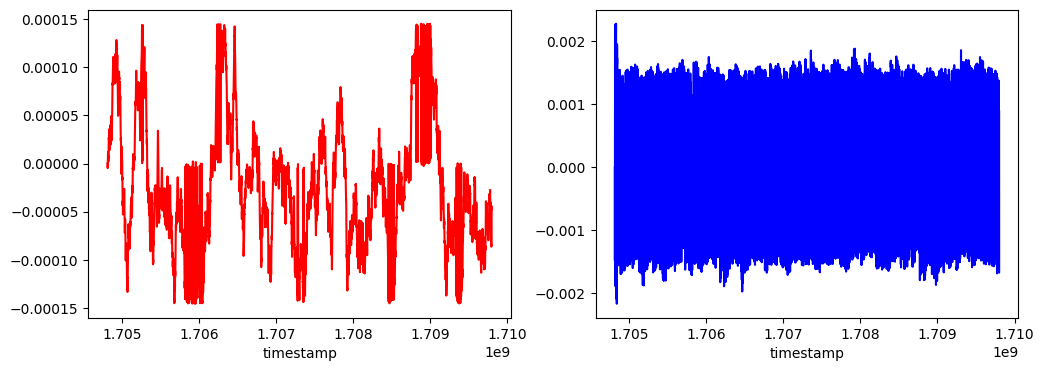

In [18]:
ng_swap_scale_delta = df.ng_swap_price_oracle - df.ng_swap_price_scale
old_swap_scale_delta = df.old_swap_price_oracle - df.old_swap_price_scale

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ng_swap_scale_delta.plot(color='r', ax=ax[0])
old_swap_scale_delta.plot(color='b', ax=ax[1])


Text(0.5, 0, 'Scale delta (price_scale - price_oracle)')

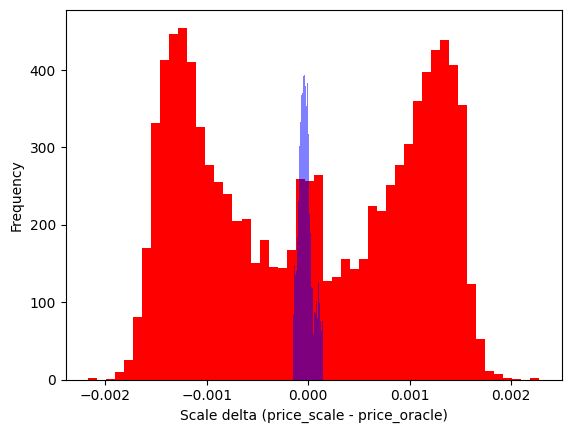

In [19]:
fig, ax = plt.subplots(1, 1,)
old_swap_scale_delta.plot.hist(ax=ax, bins=50, color='r')
ng_swap_scale_delta.plot.hist(ax=ax, bins=50, color='b', alpha=0.5)
ax.set_xlabel("Scale delta (price_scale - price_oracle)")

<Axes: xlabel='timestamp'>

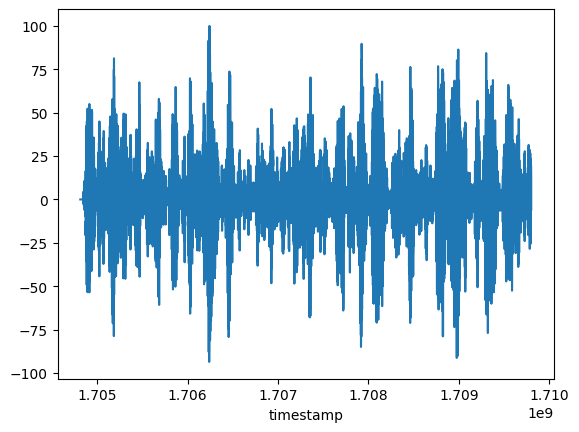

In [20]:
diff_output = (df.old_swap_out_amt).astype(float) - (df.ng_swap_out_amt).astype(float)
diff_output.plot()

The old implementation's price_scale changes more frequently whereas ng implementation's price scale does not do that as frequently. 

This is why we see such a difference in output swap amounts between the two implementations. This is not to say that the price scale in ng implementation does not change whatsoever: it does but not that often

Text(0.5, 0.98, 'blue=old, orange=ng')

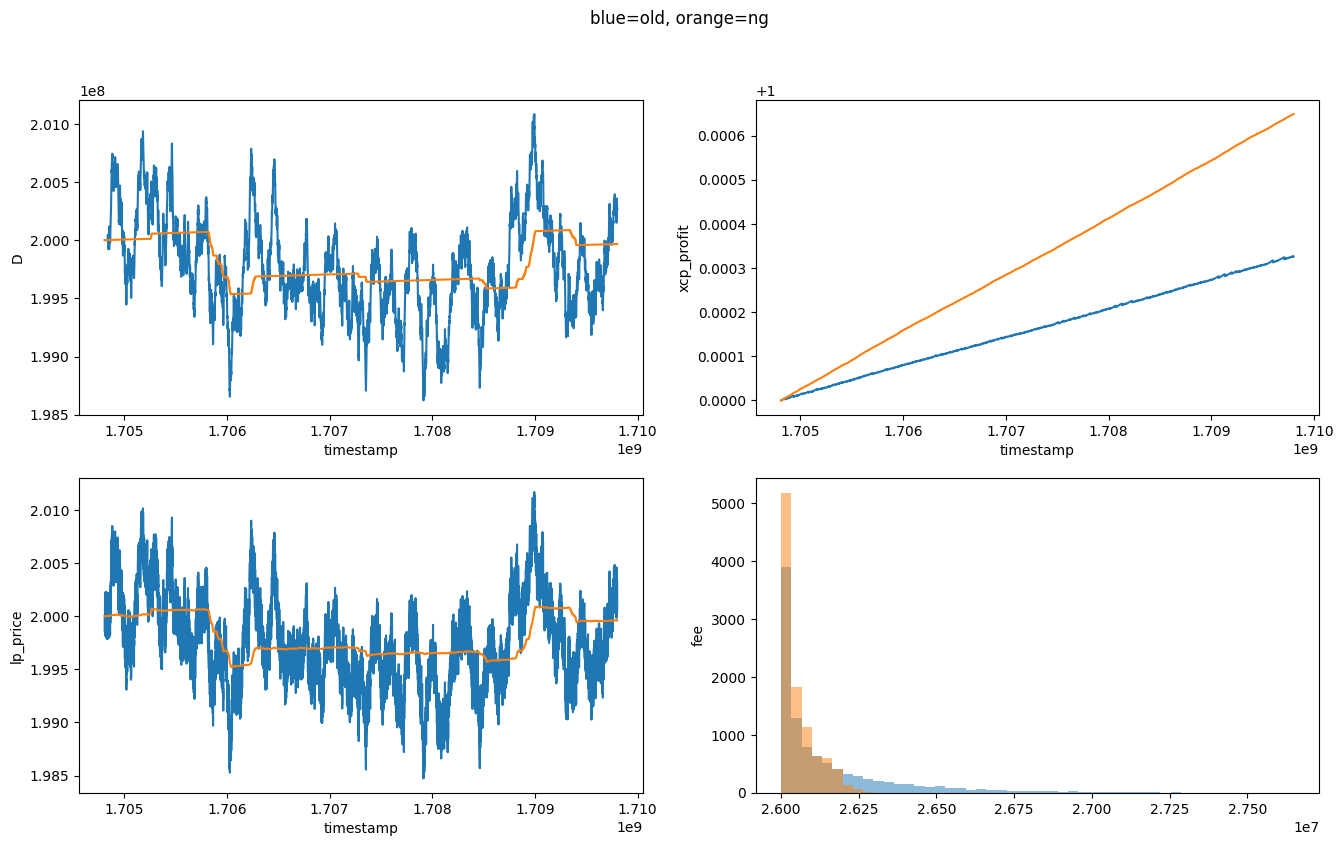

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))
df[["old_swap_D", "ng_swap_D"]].plot(ax=ax[0][0], legend=False, ylabel="D")
df[["old_swap_xcp_profit", "ng_swap_xcp_profit"]].plot(ax=ax[0][1], legend=False, ylabel="xcp_profit")
df[["old_swap_lp_price", "ng_swap_lp_price"]].plot(ax=ax[1][0], legend=False, ylabel="lp_price")
df[["old_swap_fee", "ng_swap_fee"]].plot.hist(bins=50, alpha=0.5, ax=ax[1][1], legend=False, ylabel="fee")

fig.suptitle("blue=old, orange=ng")

In [22]:
ng_swap.lp_price()

1999617015558622667

In [23]:
sum(ng_swap._storage.balances.get()) / ng_swap.totalSupply()

2.0012767111977383

How much admin fees are collected?

In [24]:
with boa.env.anchor():
    ng_swap.remove_liquidity_one_coin(10**18, i, 0, sender=trader)
    coin_a_bal = coin_a.balanceOf(fee_receiver) / coin_precisions[0]
    coin_b_bal = coin_b.balanceOf(fee_receiver) / coin_precisions[1]
    
print("ng_swap:", coin_a_bal, coin_b_bal)

ng_swap: 16196.596824299406 16241.0128639834


In [25]:
with boa.env.anchor():
    old_swap.remove_liquidity(old_swap_token.balanceOf(fee_receiver), [0, 0], sender=fee_receiver)
    coin_a_bal = coin_a.balanceOf(fee_receiver) / coin_precisions[0]
    coin_b_bal = coin_b.balanceOf(fee_receiver) / coin_precisions[1]
    
print("old_swap:", coin_a_bal, coin_b_bal)

old_swap: 16243.234799028685 16284.909845271311


In [26]:
ng_swap.fee()

26026402

In [27]:
old_swap.fee()

26331830

Fee in ng pool is overall lower because of how state prices are calculated, which explains why ng_swap has marginally lower fee collected than the old implementation.